In [31]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

In [32]:
%matplotlib inline

In [33]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [34]:
#splitting data into training and testing for validations & predicitions
#split=int(0.8*mnist_data.shape[0])

#x_train=mnist_data[:split,1:]
#x_test=mnist_data[split:1:]

#y_train=mnist_data[:split,0]
#y_test=mnist_data[split:,0]

### **# 1. MNIST DATASET**

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [36]:
#z = wx + b

In [37]:
#Hyper parameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [38]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms

# Define batch sizes for training and testing
train_batch_size = 64
test_batch_size = 1000

# Define transformations for preprocessing the MNIST dataset
# The Normalize transformation uses the global mean (0.1307) and standard deviation (0.3081)
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Loading the MNIST dataset for training
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=mnist_transforms
    ),
    batch_size=train_batch_size, shuffle=True
)

# Loading the MNIST dataset for testing
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=mnist_transforms
    ),
    batch_size=test_batch_size, shuffle=True
)


In [39]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

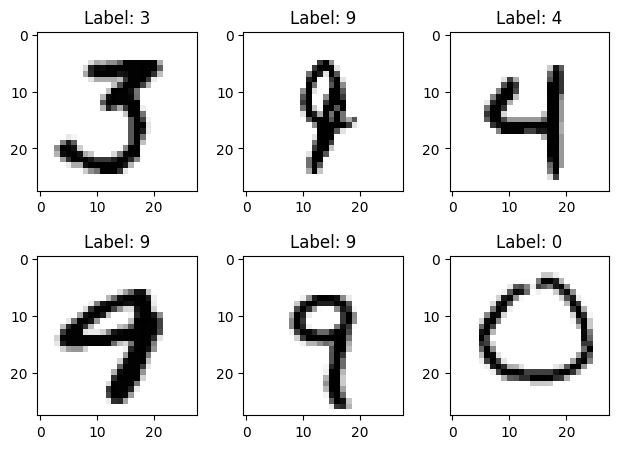

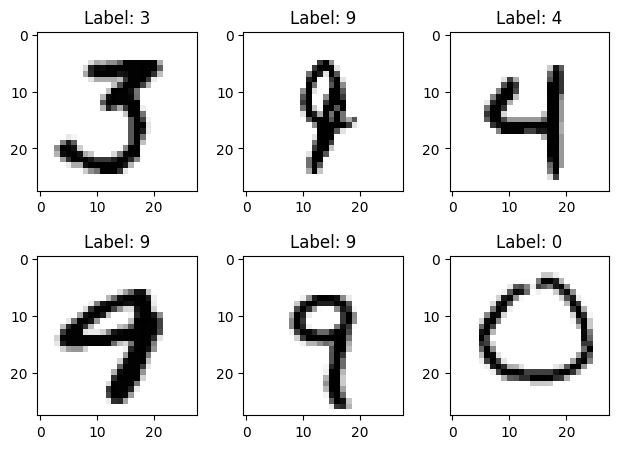

In [40]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout() #for better images(sharpening a little bit)
  plt.imshow(example_data[i][0], cmap='gray_r')
  plt.title("Label: {}".format(example_targets[i]))
fig

**Now, We will be training our Dataset/Model**

In [41]:
# Importing necessary libraries
import torch.nn as nn
import torch.nn.functional as F

# Define the Convolutional Neural Network (CNN)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # First convolutional layer: input channels = 1, output channels = 10, kernel size = 5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        # Second convolutional layer: input channels = 10, output channels = 20, kernel size = 5
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        # Dropout layer to reduce overfitting in the second convolutional layer
        self.conv2_dropout = nn.Dropout2d()
        # Fully connected layer 1: input features = 320, output features = 50
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        # Fully connected layer 2: input features = 50, output features = 10 (number of classes)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        # Apply ReLU activation and max pooling after the first convolutional layer
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        # Apply ReLU activation, dropout, and max pooling after the second convolutional layer
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), kernel_size=2))
        # Flatten the feature map into a 1D vector
        x = x.view(-1, 320)
        # Apply ReLU activation after the first fully connected layer
        x = F.relu(self.fc1(x))
        # Apply dropout during training
        x = F.dropout(x, training=self.training)
        # Apply the second fully connected layer and log softmax activation for output
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Log-Softmax over the classes

# Create an instance of the network
network = ConvNet()


In [42]:
#Now defining the loss and optimizer function
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #FOR MULTICLASS CLASSIFICATION
cmloss = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) #Can use SGD optimizer as well as *Adam*

In [43]:
# Initialize lists to track training and testing performance
train_losses = []  # Stores training loss after each log interval
train_counter = []  # Stores the corresponding training example counts
test_losses = []  # Stores testing loss
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]  # Epoch checkpoints

# Training function for a single epoch
def train(epoch):
    # Set the model to training mode
    network.train()

    # Iterate through the training dataset in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Clear the gradients of all optimized parameters
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        output = network(data)

        # Compute the negative log-likelihood loss
        loss = F.nll_loss(output, target)

        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update model parameters based on the gradients
        optimizer.step()

        # Log progress at specified intervals
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            # Append loss and training counter for visualization purposes
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * batch_size_train) + ((epoch - 1) * len(train_loader.dataset))
            )

            # Optionally save model and optimizer states
            # torch.save(network.state_dict(), '/results/model.pth')
            # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

# Note:
# - The `.state_dict()` method allows saving the model and optimizer's internal states for later use.
# - The `log_interval` variable should be defined earlier (e.g., `log_interval = 10`).
# - `batch_size_train` should correspond to the training batch size, e.g., `batch_size_train = 64`.


In [44]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



In [45]:
#test()
#for epoch in range(1,n_epochs + 1):
 # train(epoch)
  #test()

In [46]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-41-4ffea189aaea>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


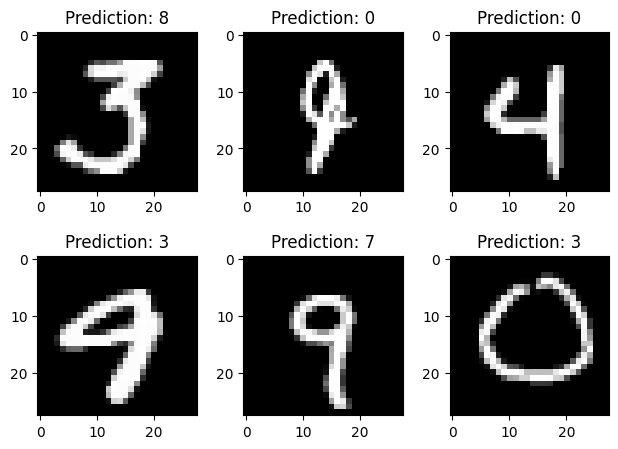

In [47]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  fig

## ***2.CIFAR10 DATASET***

 We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [48]:
#importing libraries
import torch
import torchvision
import torchvision.transforms as transforms

In [49]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transformation: Convert images to tensors and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize channels to [-1, 1]
])

# Batch size: Number of images in each batch
batch_size = 5  

# Load CIFAR-10 Training Dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to store the data
    train=True,  # Specify the training dataset
    download=True,  # Download the dataset if not available
    transform=transform  # Apply transformations
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

# Load CIFAR-10 Testing Dataset
testset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to store the data
    train=False,  # Specify the testing dataset
    download=True,  # Download the dataset if not available
    transform=transform  # Apply transformations
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# CIFAR-10 Class Labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Example: Checking the dataset and loader details
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Classes in the CIFAR-10 Dataset: {classes}")


Files already downloaded and verified
Files already downloaded and verified


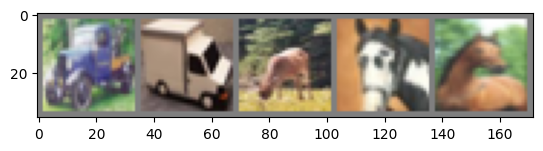

truck truck deer  horse horse


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#to get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#showing images
imshow(torchvision.utils.make_grid(images))
#printing labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [51]:
# Define the Convolutional Neural Network (CNN)
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # Input: 3 channels (RGB), Output: 6 feature maps
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer with a 2x2 filter
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  # Input: 6 channels, Output: 16 feature maps

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)  # 16 feature maps, each 5x5, flattened
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Hidden layer
        self.fc3 = nn.Linear(in_features=84, out_features=10)  # Output layer for 10 classes (CIFAR-10)

    def forward(self, x):
        # Pass through convolutional layers
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, start_dim=1)  # Keep batch dimension, flatten the rest
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))  # Fully connected layer -> ReLU
        x = F.relu(self.fc2(x))  # Fully connected layer -> ReLU
        x = self.fc3(x)  # Output layer (no activation, raw scores for classification)
        
        return x

# Instantiate the network
model = CNN()

# Display the network architecture
print(model)


In [52]:
#Creating a loss function and an Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the Network:

In [53]:
for epoch in range(4):  #loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.188
[1,  4000] loss: 1.838
[1,  6000] loss: 1.620
[1,  8000] loss: 1.528
[1, 10000] loss: 1.452
[2,  2000] loss: 1.389
[2,  4000] loss: 1.361
[2,  6000] loss: 1.322
[2,  8000] loss: 1.287
[2, 10000] loss: 1.276
[3,  2000] loss: 1.223
[3,  4000] loss: 1.210
[3,  6000] loss: 1.196
[3,  8000] loss: 1.187
[3, 10000] loss: 1.158
[4,  2000] loss: 1.125
[4,  4000] loss: 1.100
[4,  6000] loss: 1.106
[4,  8000] loss: 1.090
[4, 10000] loss: 1.107
Finished Training


In [54]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH) #Saving our trained model

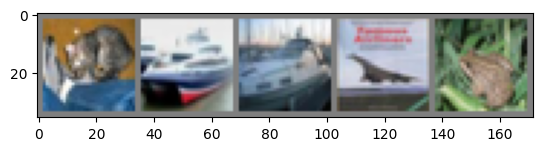

Images of:  cat   ship  ship  plane frog 


In [61]:
#testing the network on the test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('Images of: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [56]:
net = Net()
net.load_state_dict(torch.load(PATH)) #loading back in the saved model

<All keys matched successfully>

In [57]:
outputs = net(images)

In [58]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

Predicted:  cat   ship  ship  plane frog 


In [59]:
#Checking the network performance over the entire dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [60]:
# Prepare dictionaries to count predictions for each class
correct_pred = {classname: 0 for classname in classes}  # To track correct predictions per class
total_pred = {classname: 0 for classname in classes}    # To track total predictions per class

# Evaluate the model (no gradients required)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)  # Forward pass
        _, predictions = torch.max(outputs, 1)  # Get the class with the highest score (index)

        # Collect correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:  # Correct prediction
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1  # Total predictions per class

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]  # Calculate percentage accuracy
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 69.2 %
Accuracy for class: car   is 78.7 %
Accuracy for class: bird  is 45.7 %
Accuracy for class: cat   is 44.1 %
Accuracy for class: deer  is 51.1 %
Accuracy for class: dog   is 44.0 %
Accuracy for class: frog  is 70.7 %
Accuracy for class: horse is 62.4 %
Accuracy for class: ship  is 73.7 %
Accuracy for class: truck is 64.3 %
